# Soy Future Market Analysis Report

## Market Info
#### Symbol Convention
[Base Symbol]+[Month Code]+[Year]

- For example, ```ZSQ25``` is the Chicago soybean future with expiration in September 2025.
- ```ZM=F``` refers to the **nearest to expiration** Chicago soy meal futures contract. For example, from March to April, the ```ZM=F``` tracks the May futures ```ZMK```.

#### Quick Summary
- Like wheat, soybeans and sunflower seeds aren't generally used or consumed directly, but require further processing. Unlike wheat, both soy and sunflower have applications for other food-production chains; soy is a valuable protein source for livestock feed, and both soy and sunflower oil are major vegetable fats used in food, food products, and industrial applications.

| Commodity Name     | Symbol | Key Growing Regions    | Primary Uses                       | Planting Season | Harvest Season | Vulnerable to                              | Expiry Month                           |
|--------------------|--------|------------------------|------------------------------------|-----------------|----------------|--------------------------------------------|----------------------------------------|
| **Whole Soybeans** | `ZS`   | Central U.S. (Plains)  | Edamame, soy sauce, meat substitutes           | Mar-Apr         | Sep-Oct        | leaf disease, cold damage & drought        | Jan, Mar, May, Jul, Aug, Sep, Oct, Dec (F, H, K, N, Q, U, X) |
| **Soybean Oil**    | `ZL`   | N/A  | Vegetable oil, food additives, ink, paint     | N/A             | N/A        | N/A            | Jan, Mar, May, Jul, Aug, Sep, Oct, Dec (F, H, K, N, Q, U, X) |
| **Soybean Meal**   | `ZM`   | N/A | Protein isolate, tofu, soy milk                     | N/A             | N/A        | N/A | Jan, Mar, May, Jul, Aug, Sep, Oct, Dec (F, H, K, N, Q, U, X) |

#### Geopolitical & Export Demand
- The U.S. is the world's second largest producer of soy, after Brazil.
- China is the largest importer from the U.S., for ~$20Bn/year as of 2025.
- Mexico and the EU also import ~$2Bn/year of soy.
- Large stocks of, production capacities of, and agro-industrial demand for soy all mean that the soy futures market is highly liquid.

#### Last trading day
- The business day before the 15th calendar day of the contract month. Usually, it would be the 14th of that day at 1:20pm CT.
- The soy is already in the warehouse before the expiration date. Once the ownership is transferred to the long trader, the long trader must pay the storage fees.
- After the last trading day, the buyer of the contract must take delivery. This will incur daily warehouse fee, handling fees and delivery fees.
- Most trades will close their positions before the First Notice day, or the last trading day.

In [6]:
import yfinance as yf
import pandas as pd
import pandas_datareader as pdr
import seaborn as sns
import matplotlib.pyplot as plt
import requests
import numpy as np

# %pip install --upgrade yfinance
# %pip install pandas-datareader

api_key = "7BACC84D-4D4E-31CE-9828-0EAF5D6338DB"
USDA_url = 'https://quickstats.nass.usda.gov/api/api_GET/'

# KPIs - What Do We Want Here?
We need to scope this better and/or at all! One operationalization of what we seemed to agree we wanted when we met:

- To predict the next day's closing price, in which case maybe all we need to do is linear regression on data from the last month. (-> model candidate is linear drift + RW?)
    - Could take day-of weather *in Chicago* into account (weather -> mood -> trading inefficiencies) - categorical (type of weather) or otherwise?
    - Could take some "average rainfall" measure from a rolling average from some fixed time period in the past (e.g. 105--75 days ago)
    - Would need to compare model not just in terms of MSE but also whether they drive profitable trading strategies!
    - Might want to look at beta here too in that case? (Tradeoff between returns and volatility.)
    - "Canonical" trading strategy:
        - If tomorrow's soy future price is very different from today's (as might be naively guessed), do something complicated with soy futures
        - Else, stick it in an index fund
        - -> Need to compare returns from soy futures trading vs index fund, even in the best case where we're somehow one-day-prescient a/b soy futures prices: in that very happy case, is this even worth it?

- ...Could also be something else?

Notes:
- VARIMA (Vector ARIMA) - multiple time-series which might be correlated
    - *Target* variable is vector-valued and so is the input
- Other ARIMA+ (ARIMAX, VARIMAX, linear regression with ARIMA errors, autoregressive distributed lag model)
    - ARIMAX: Multiple input variables
    - ARDL: very similar to autoregressive model + also some covariates in the present as opposed to just the past

- ARIMAX for existing price data + day-of weather in Chicago
- maybe VARIMA for multiple agricultural futures at once?
- Random forest/XGBoost for categorical output re: trading strategy? Rise a lot, wash, sink a lot.
- Tianhao will write backtesting for the simple trading strategy 
- Sentiment analysis for news as additional categorical input?

## Market Data Analysis (Soy)

In [12]:
## ONLY RUN THIS FOR NEW DATA

# Obtaining the nearest to expiration soy future - these prices come from whichever contract is closest to closing, whatever that may be at the index time.

ZS = yf.Ticker("ZS=F")
ZL = yf.Ticker("ZL=F")
ZM = yf.Ticker("ZM=F")
ZS_data = ZS.history(start ="2019-01-01", end ="2024-12-31")
ZL_data = ZL.history(start ="2019-01-01", end ="2024-12-31")
ZM_data = ZM.history(start ="2019-01-01", end ="2024-12-31")

ZS_data.to_csv('ZS-data.csv')
ZL_data.to_csv('ZL-data.csv')
ZM_data.to_csv('ZM-data.csv')


In [42]:
from datetime import datetime
ZS_data = pd.read_csv('ZS-data.csv', parse_dates=['Date'])
ZL_data = pd.read_csv('ZL-data.csv', parse_dates=['Date'])
ZM_data = pd.read_csv('ZM-data.csv', parse_dates=['Date'])

ZS_data['Date'] = pd.to_datetime(ZS_data['Date'], utc=True)
ZL_data['Date'] = pd.to_datetime(ZL_data['Date'], utc=True)
ZM_data['Date'] = pd.to_datetime(ZM_data['Date'], utc=True)

ZS_data.set_index('Date', inplace=True)
ZL_data.set_index('Date', inplace=True)
ZM_data.set_index('Date', inplace=True)

ZS_data['Year'] = ZS_data.index.year
ZS_data['Month'] = ZS_data.index.month
ZS_data['Day'] = ZS_data.index.day
ZS_data['Day_Of_Year'] = ZS_data.index.dayofyear
ZL_data['Year'] = ZL_data.index.year
ZL_data['Month'] = ZL_data.index.month
ZL_data['Day'] = ZL_data.index.day
ZL_data['Day_Of_Year'] = ZL_data.index.dayofyear
ZM_data['Year'] = ZM_data.index.year
ZM_data['Month'] = ZM_data.index.month
ZM_data['Day'] = ZM_data.index.day
ZM_data['Day_Of_Year'] = ZM_data.index.dayofyear

ZS_dict = {}
ZL_dict = {}
ZM_dict = {}

for col in ZS_data.columns:
    # ZS_dict[col] = 'ZS ' + col
    ZL_dict[col] = 'ZL ' + col
    ZM_dict[col] = 'ZM ' + col

ZS_data.rename(columns=ZS_dict, inplace=True)
ZL_data.rename(columns=ZL_dict, inplace=True)
ZM_data.rename(columns=ZM_dict, inplace=True)

### Trading Volume Analysis

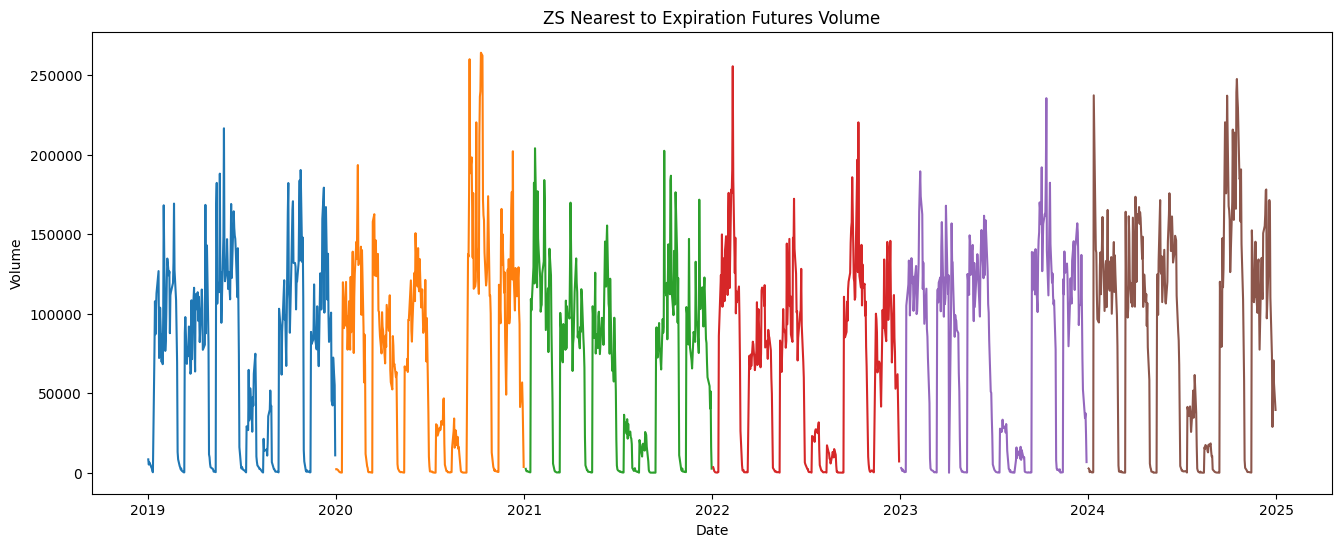

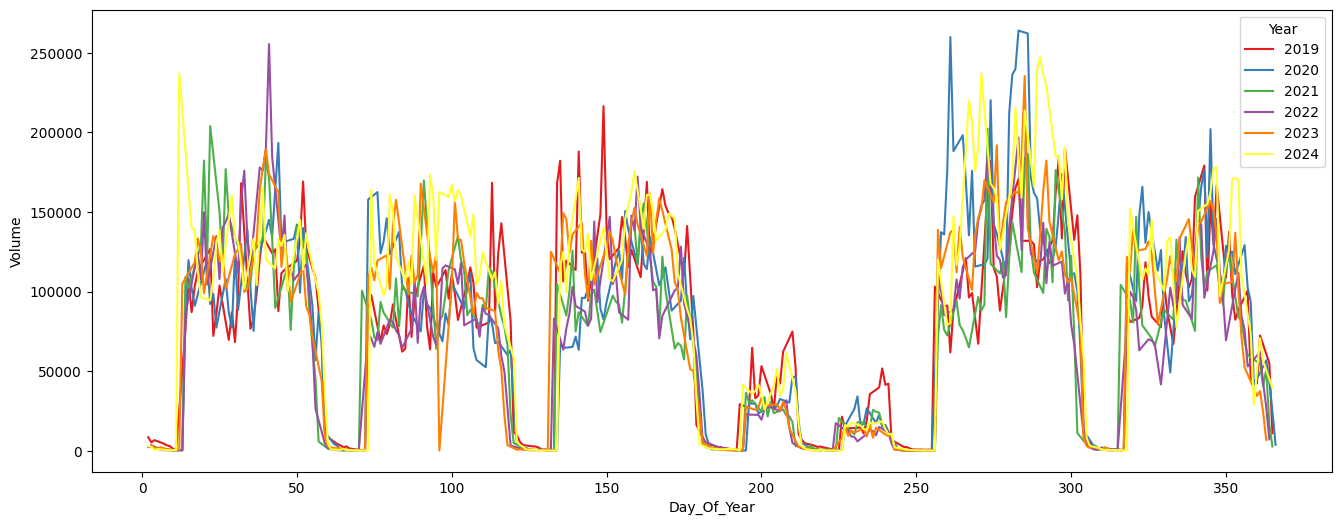

In [43]:
plt.figure(figsize = (16,6))
plt.title("ZS Nearest to Expiration Futures Volume")
for year in ZS_data['Year'].unique():  # Loop through each unique year
    yearly_data = ZS_data[ZS_data['Year'] == year]
    sns.lineplot(x = 'Date', y = 'Volume', data = yearly_data)
plt.show()

plt.figure(figsize = (16,6))
sns.lineplot(x = 'Day_Of_Year', y = 'Volume', data = ZS_data, hue ='Year', palette='Set1')
plt.show()

There are 8 near-zero volume periods in each year, which are precisely the days just after the last trading days. We also note that during the stretch from July to August, the trading volumes are low commensurate with the fact that during this part of the year, the futures contracts come due monthly repeatedly - the yearly cycle overall flips between equal numbers of one-month and two-month separations. Overall, there are five major "trading seasons" for whole soybeans. We will remove some of those data when analyzing the volume.

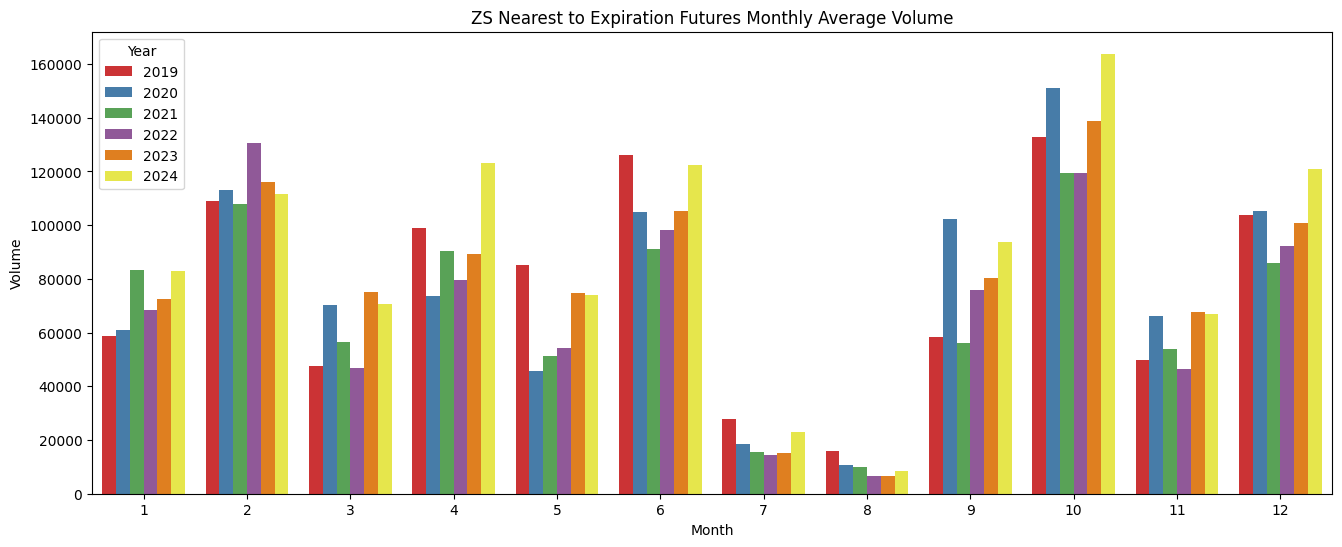

In [44]:
monthly_average = ZS_data.groupby(['Year', 'Month']).Volume.agg('mean').reset_index()

plt.figure(figsize = (16,6))
plt.title("ZS Nearest to Expiration Futures Monthly Average Volume")
sns.barplot(x = 'Month', y = 'Volume', data = monthly_average, hue = 'Year', palette='Set1')
# sns.barplot(x = 'Month', y = 'Volume', data = monthly_average)
plt.show()

The trading volumes in January, March, May, September and November are all lower than might be expected, and the trading volumes in July and August are especially low. This is partially because those months are among the expiration months, so that the data are coming from the nearest to expiration Futures - recall that after the final trading day, no transactions are allowed. While the July and August slump are, once again, explained by the higher frequency of contract expiry during that time of year, we are uncertain as to the reason for the consistent November slump.

### Price Analysis

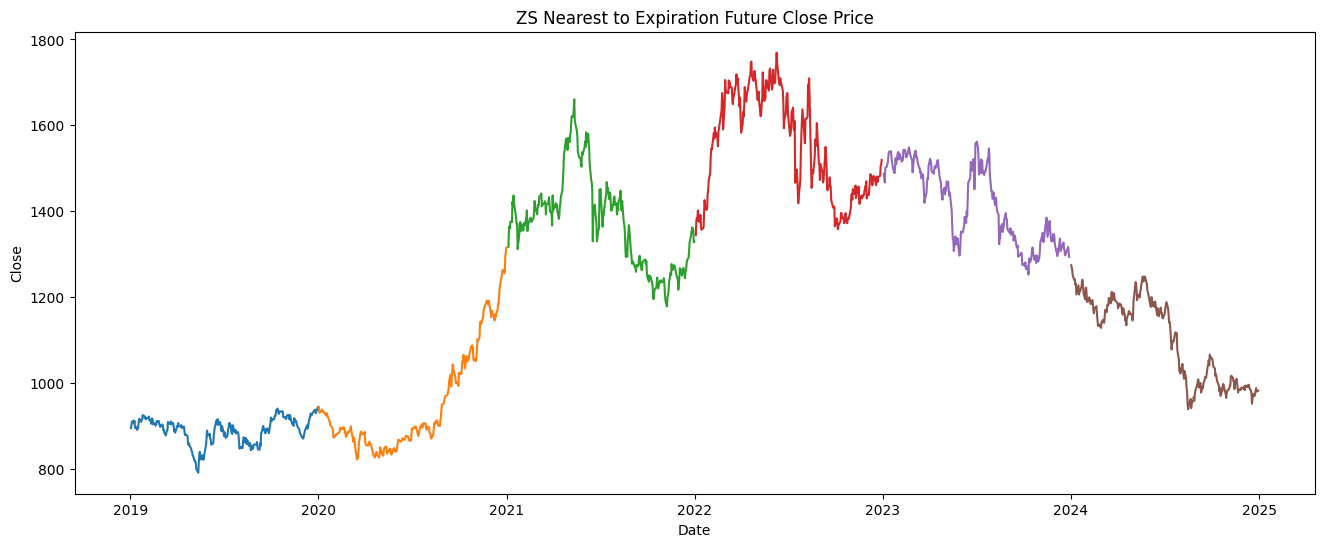

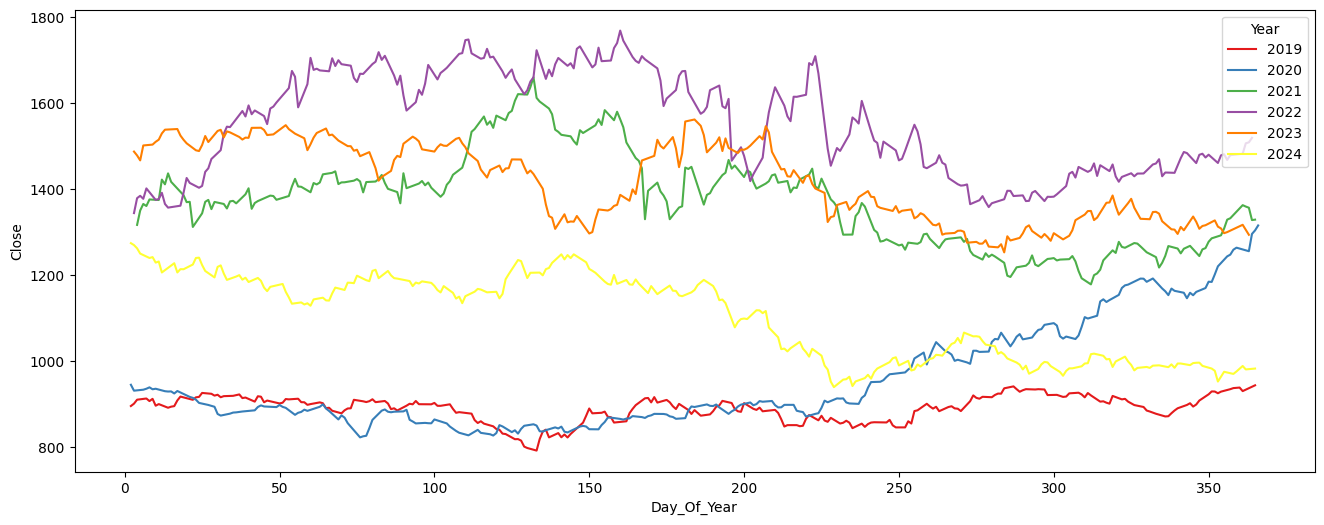

In [46]:
plt.figure(figsize = (16,6))
plt.title("ZS Nearest to Expiration Future Close Price")
for year in ZS_data['Year'].unique():  # Loop through each unique year
    yearly_data = ZS_data[ZS_data['Year'] == year]
    sns.lineplot(x = 'Date', y = 'Close', data = yearly_data)
plt.show()

plt.figure(figsize = (16,6))
sns.lineplot(x = 'Day_Of_Year', y = 'Close', data = ZS_data, hue ='Year', palette='Set1')
plt.show()

From the graphs above and below, we observe no clear evidence of a strong seasonality component to the price data.

C:\Users\Lorxus\AppData\Local\Temp\ipykernel_26484\2325954694.py:6: RuntimeWarning: divide by zero encountered in divide
  plt.plot(1 / frequencies, power)


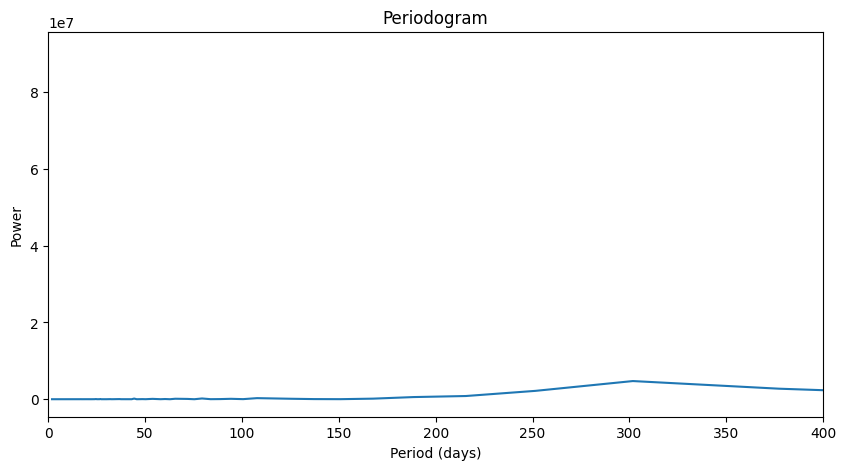

In [47]:
from scipy.signal import periodogram

frequencies, power = periodogram(ZS_data['Close'].dropna())

plt.figure(figsize=(10, 5))
plt.plot(1 / frequencies, power)
plt.xlabel("Period (days)")
plt.ylabel("Power")
plt.title("Periodogram")
plt.xlim(0, 400)  # Limit x-axis to reasonable periods
plt.show()

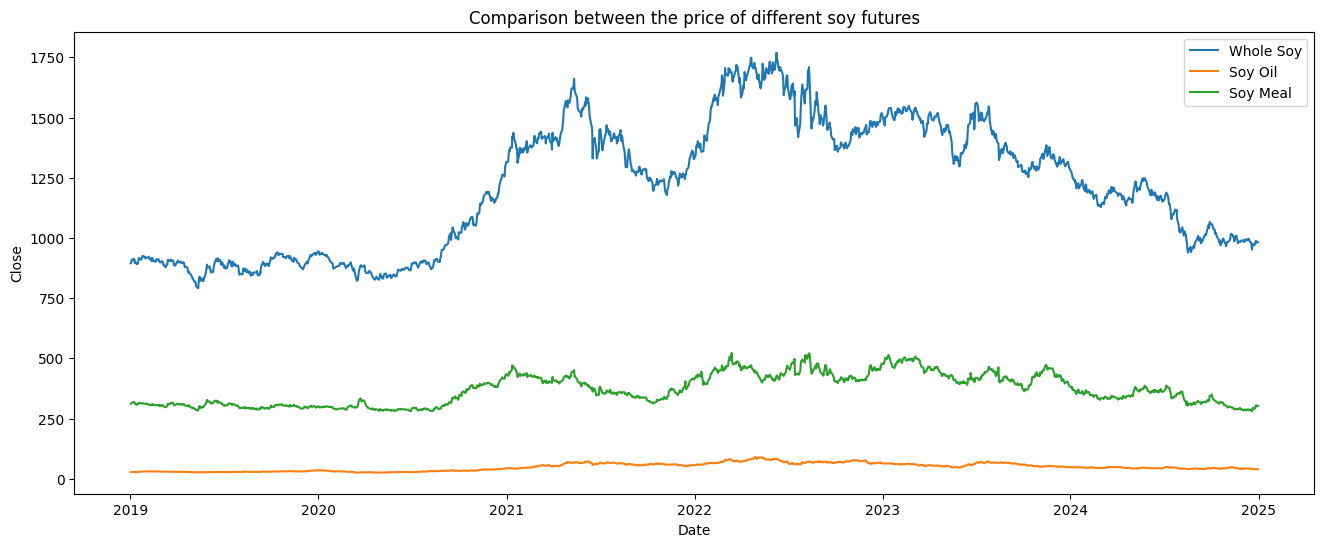

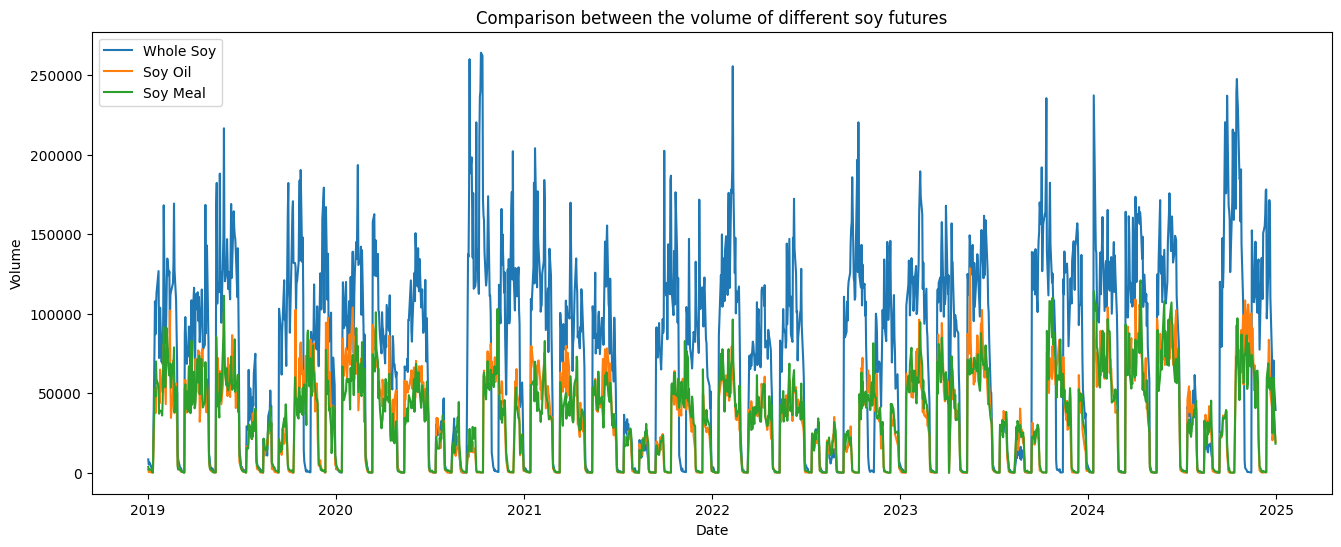

In [52]:
plt.figure(figsize=(16, 6))
plt.title("Comparison between the price of different soy futures")
sns.lineplot(x = 'Date', y = 'Close', data = ZS_data, label = "Whole Soy")
sns.lineplot(x = 'Date', y = 'ZL Close', data = ZL_data, label = "Soy Oil")
sns.lineplot(x = 'Date', y = 'ZM Close', data = ZM_data, label = "Soy Meal")
plt.show()

plt.figure(figsize=(16, 6))
plt.title("Comparison between the volume of different soy futures")
sns.lineplot(x = 'Date', y = 'Volume', data = ZS_data, label = "Whole Soy")
sns.lineplot(x = 'Date', y = 'ZL Volume', data = ZL_data, label = "Soy Oil")
sns.lineplot(x = 'Date', y = 'ZM Volume', data = ZM_data, label = "Soy Meal")
plt.show()

Whole soy futures dominate the trading volume. The price of whole soy is consistently vastly larger than the sum of soy oil and soy meal, which starkly disconfirms one natural "toy model" analysis of soy pricing. We will instead look for a linear regression of whole soy prices in terms of prices for soy meal and soy oil. 

### Other soy indexes and initial analysis for soy

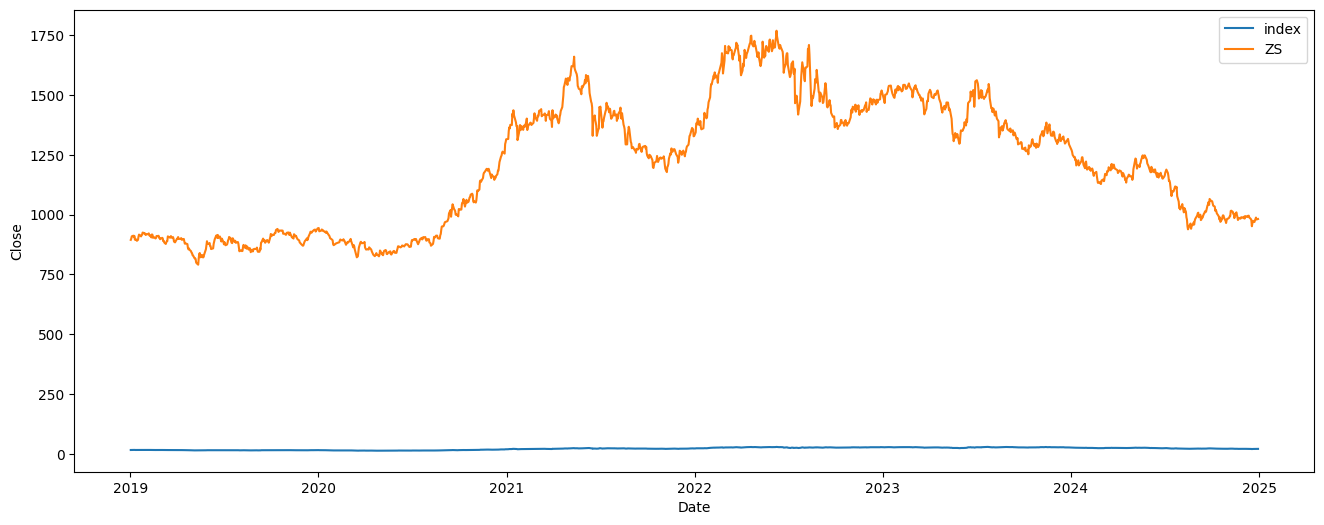

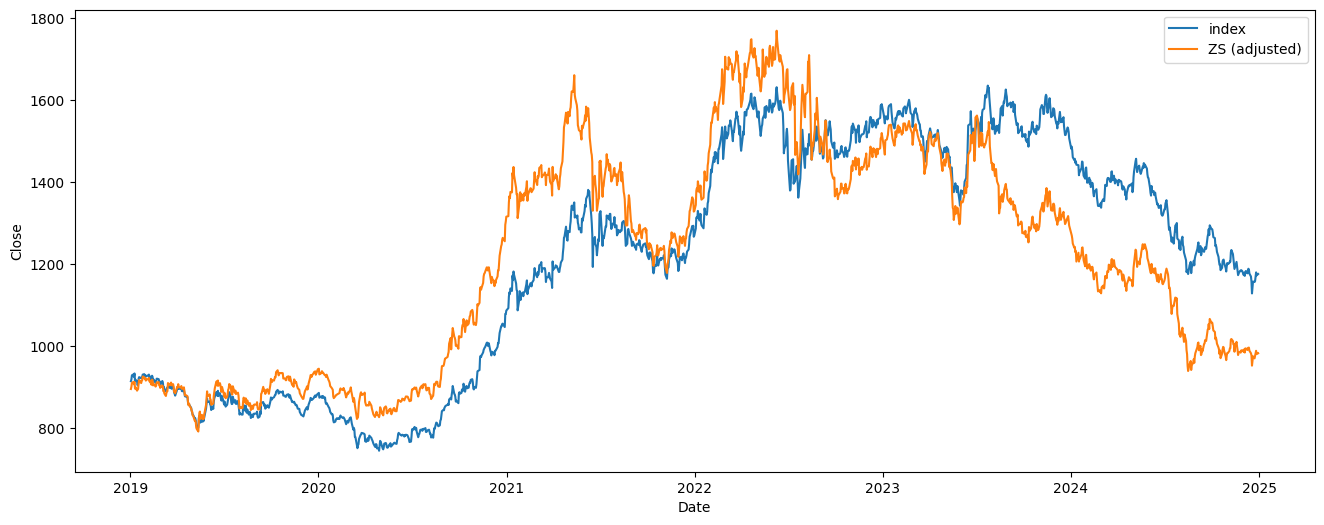

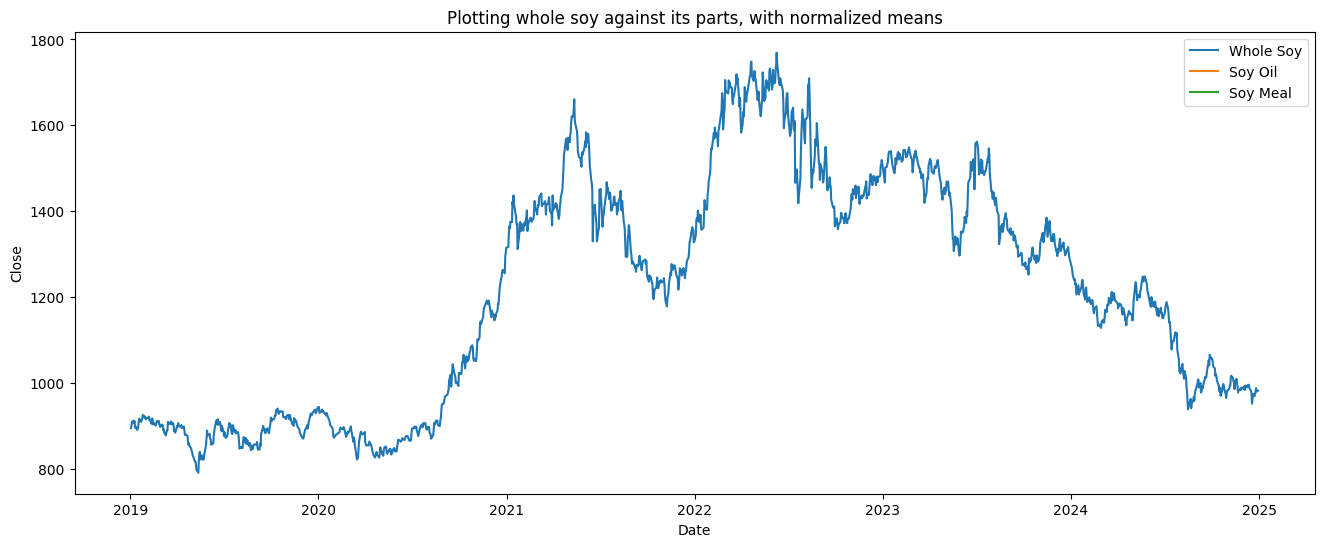

In [53]:
# The Teucrium funds are like index funds for futures, and are almost a scaled version of the commodity price.
ticker = 'SOYB'
data = yf.Ticker(ticker).history(start ="2019-01-01", end ="2024-12-31")

plt.figure(figsize = (16,6))
sns.lineplot(x = 'Date', y = 'Close', data = data, label = "index")
sns.lineplot(x = 'Date', y = 'Close', data = ZS_data, label = "ZS")
plt.show()

data = data * (ZS_data.mean()/data.mean())

# A picture of the two soybean tickers, regularized so that the SOYB-derived data has the same mean as the ZS data.
plt.figure(figsize = (16,6))
sns.lineplot(x = 'Date', y = 'Close', data = data, label = "index")
sns.lineplot(x = 'Date', y = 'Close', data = ZS_data, label = "ZS (adjusted)")
plt.show()

plt.figure(figsize=(16, 6))
plt.title("Plotting whole soy against its parts, with normalized means")
sns.lineplot(x = 'Date', y = 'Close', data = ZS_data, label = "Whole Soy")
sns.lineplot(x = 'Date', y = 'Close', data = ZL_data / (ZL_data.mean()/ZS_data.mean()), label = "Soy Oil")
sns.lineplot(x = 'Date', y = 'Close', data = ZM_data / (ZM_data.mean()/ZS_data.mean()), label = "Soy Meal")
plt.show()

### Linear regressions: whole soy vs soy parts
We'll do two simple linear regressions for exploratory data analysis: simple linear regressions of whole soy daily closing price over each of soy oil price and soy meal price, and then a multiple linear regression over both at once. 

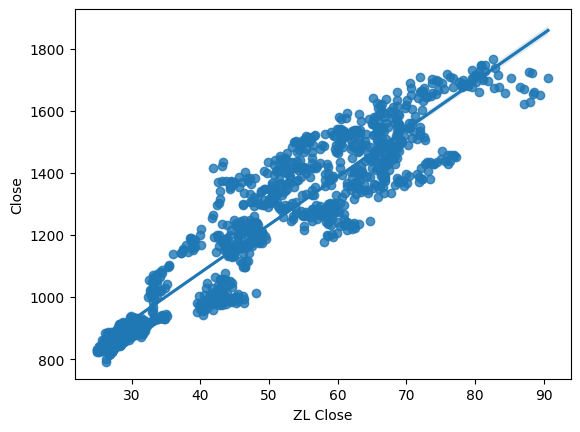

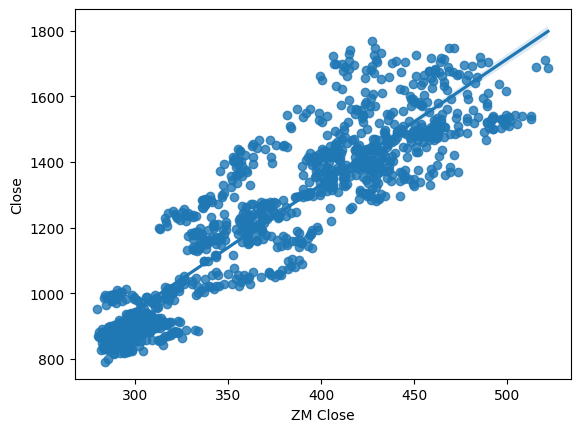

[[15.43898356]] [460.98107354]
[[3.82685595]] [-199.77908305]
[[9.56706197 1.9256515 ]] [36.28347389]


In [73]:
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import KFold
from sklearn.model_selection import train_test_split
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import root_mean_squared_error 

ZS_train, ZS_test = train_test_split(ZS_data, test_size=0.2, random_state=518)
train_indices = ZS_train.index
test_indices = ZS_test.index

ZL_train = ZL_data.loc[ZL_data.index.isin(train_indices)]
ZL_test = ZL_data.loc[ZL_data.index.isin(test_indices)]
ZM_train = ZM_data.loc[ZM_data.index.isin(train_indices)]
ZM_test = ZM_data.loc[ZM_data.index.isin(test_indices)]

ZZ_data = pd.concat([ZL_data, ZM_data], axis=1)
ZZ_train = ZZ_data.loc[ZZ_data.index.isin(train_indices)]
ZZ_test = ZZ_data.loc[ZZ_data.index.isin(test_indices)]

ZW_data = pd.concat([ZL_data, ZM_data, ZS_data], axis=1)
ZW_train = ZW_data.loc[ZW_data.index.isin(train_indices)]
ZW_test = ZW_data.loc[ZW_data.index.isin(test_indices)]

# ZS_train, ZS_test = train_test_split(ZS_data, test_size=0.2)
# ZL_train, ZL_test = train_test_split(ZL_data, test_size=0.2)
# ZM_train, ZM_test = train_test_split(ZM_data, test_size=0.2)
# ZZ_data = pd.concat([ZL_data, ZM_data], axis=1, ignore_index=False) 
# ZZ_train, ZZ_test = train_test_split(ZZ_data, test_size=0.2)

# ZW_data = pd.concat([ZL_data, ZM_data, ZS_data], axis=1, ignore_index=False)
# ZW_train, ZW_test = train_test_split(ZW_data, test_size=0.2) 

oil_regression = LinearRegression()
meal_regression = LinearRegression()
multi_regression = LinearRegression()

oil_regression.fit(ZW_train[['ZL Close']], ZW_train[['Close']])
meal_regression.fit(ZW_train[['ZM Close']], ZW_train[['Close']])
multi_regression.fit(ZW_train[['ZL Close', 'ZM Close']] , ZW_train[['Close']])

# print(ZZ_train.filter(like='Close'))

# SLR plots for whole soy vs oil prices and whole soy vs meal prices

sns.regplot(data=ZW_train, x = 'ZL Close', y = 'Close')
plt.show()
sns.regplot(data=ZW_train, x = 'ZM Close', y = 'Close')
plt.show()

print(oil_regression.coef_, oil_regression.intercept_)
print(meal_regression.coef_, meal_regression.intercept_)
print(multi_regression.coef_, multi_regression.intercept_)

# Stationarity Testing and Correlograms (To-Do)
Probably we should believe that the day-on-day changes of this time series are stationary, but that's worth testing - it would be meaningful if it were not.

More sensible it looks to turn out that the actual daily prices are stationary, but the day-on-day changes are dependent on the most recent day (obviously).

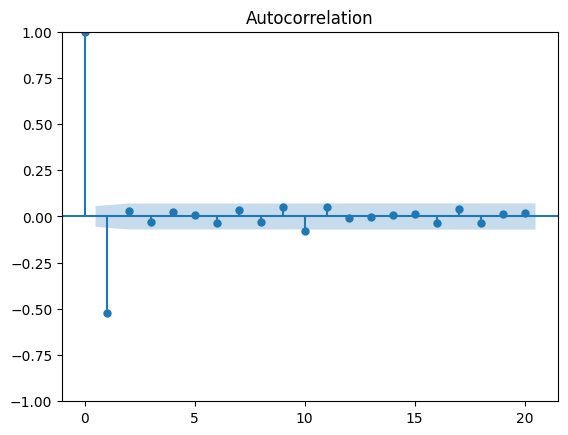

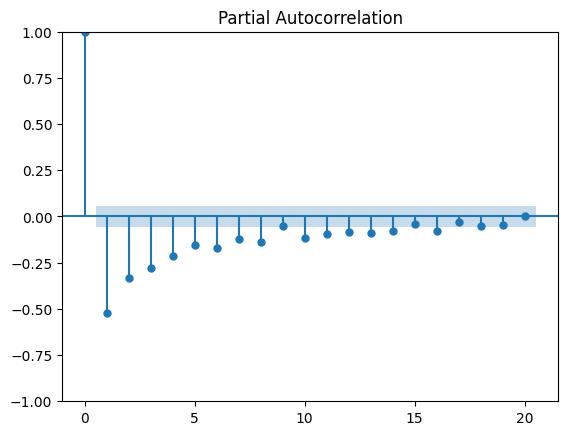

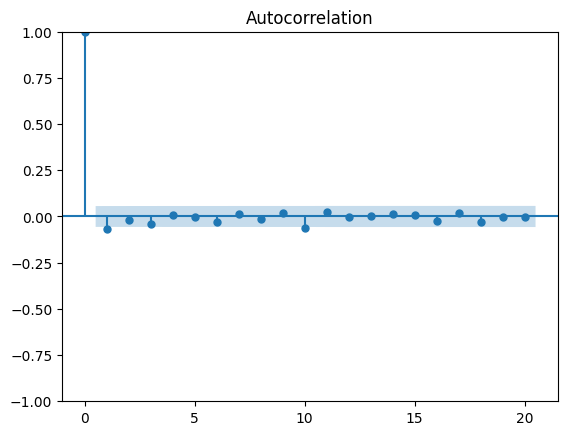

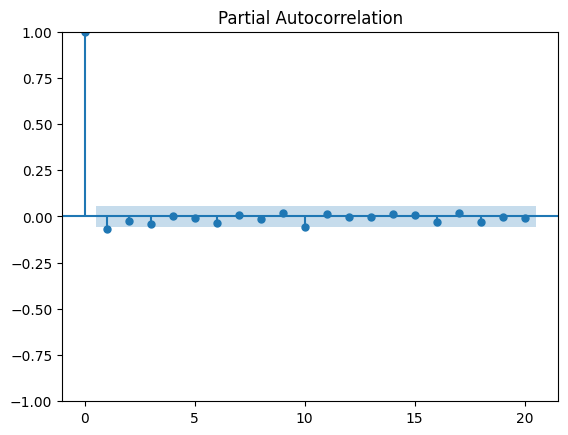

In [ ]:
import statsmodels.api as sm

# Dickey-Fuller test - stationarity, trend-stationarity
ZS_td = ZS_train['Close'] - ZS_train['Close'].shift(1)  # day-on-day change
ZS_td = ZS_td.dropna()
sm.graphics.tsa.plot_acf(ZS_td, lags = 20)
plt.show()
sm.graphics.tsa.plot_pacf(ZS_td, lags = 20)
plt.show()
sm.graphics.tsa.plot_acf(ZS_train['Close'], lags = 20)
plt.show()
sm.graphics.tsa.plot_pacf(ZS_train['Close'], lags = 20)
plt.show()


# Cross-Validation (To-Do)

In [ ]:
# Make a KFold object
# remember to set a random_state and set shuffle = True
num_splits = 5
num_models = 4
kfold = KFold(num_splits, shuffle=True, random_state=518)

# This array will hold the mse for each model and split

s = np.zeros((num_models, num_splits))

# set a split counter
i = 0

# loop through the kfold here
for train_index, test_index in kfold.split(ZS_train):
    # cv training set
    ZS_tt = ZS_train.iloc[train_index]
    
    # cv holdout set
    ZS_ho = ZS_train.iloc[test_index]
    
    # "Fit" mean and get holdout root mean squared error for the baseline model.
    # No need to use an sklearn function:  just get the mean.  
    # baseline_pred should be a numpy array with the same number of elements as ZS_ho

    baseline_pred = ZS_tt.median_house_value.mean()*np.ones(len(ZS_ho))
    rmses[0, i] = root_mean_squared_error(ZS_ho.median_house_value, baseline_pred)
    
    # Fit and get ho rmse for slr model
    slr = LinearRegression()
    slr.fit(ZS_tt[['median_income']], ZS_tt.median_house_value)
    rmses[1, i] = root_mean_squared_error(ZS_ho.median_house_value, slr.predict(ZS_ho[['median_income']]))
    
    ## Fit and get ho mse for mlr model
    mlr = LinearRegression()
    mlr.fit(ZS_tt[['median_income', 'households']], ZS_tt.median_house_value)
    rmses[2, i] = root_mean_squared_error(ZS_ho.median_house_value, mlr.predict(ZS_ho[['median_income', 'households']])) 
    
    ## Fit and get ho rmse for the spatial model
    knn = KNeighborsRegressor()
    knn.fit(ZS_tt[['latitude', 'longitude']], ZS_tt.median_house_value)
    rmses[3, i] = root_mean_squared_error(ZS_ho.median_house_value, knn.predict(ZS_ho[['latitude', 'longitude']]))
    
    i = i + 1

## Data from the USDA (United States Department of Agriculture)

In [52]:
params = {
    'key': api_key,
    'commodity_desc': 'WHEAT',
    'statisticcat_desc': 'PRODUCTION',
    'agg_level_desc': 'STATE',
#    'class_desc': 'WINTER, RED, SOFT',
    'year__GE': 2012,  # Adjust the year range as needed
    'format': 'JSON',
    'domaincat_desc': 'NOT SPECIFIED',
}

response = requests.post(USDA_url, params=params)

SRW_percentage = pd.DataFrame()
HRW_percentage = pd.DataFrame()
HRS_percentage = pd.DataFrame()
df = pd.DataFrame()

if response.status_code == 200:
    data = response.json()

    # Convert JSON response to DataFrame
    df = pd.DataFrame(data['data'])  # Assuming 'data' is the key containing records
    df['year'] = pd.to_numeric(df['year'])
    df['Value'] = df['Value'].str.replace(',', '', regex=True)
    df['Value'] = pd.to_numeric(df['Value'], errors='coerce')

    # Select only relevant columns
    SRW_percentage = df[df['class_desc'] == 'WINTER, RED, SOFT'][['year', 'state_name', 'class_desc' ,'Value', 'unit_desc']]
    HRW_percentage = df[df['class_desc'] == 'WINTER, RED, HARD'][['year', 'state_name', 'class_desc' ,'Value', 'unit_desc']]
    HRS_percentage = df[df['class_desc'] == 'SPRING, RED, HARD'][['year', 'state_name', 'class_desc' ,'Value', 'unit_desc']]
else:
    print(f"Error: {response.status_code}")

In [58]:
production = df[df['class_desc'] == 'ALL CLASSES']
result = production[(production['state_name'] == 'KANSAS') & (production['unit_desc'] == 'BU')]
result[['Value', 'unit_desc', 'year' ,'source_desc', 'short_desc', 'domaincat_desc', 'state_name']]

,Value,unit_desc,year,source_desc,short_desc,domaincat_desc,state_name
42,246471132.0,BU,2022,CENSUS,"WHEAT - PRODUCTION, MEASURED IN BU",NOT SPECIFIED,KANSAS
43,319315035.0,BU,2017,CENSUS,"WHEAT - PRODUCTION, MEASURED IN BU",NOT SPECIFIED,KANSAS
44,359484644.0,BU,2012,CENSUS,"WHEAT - PRODUCTION, MEASURED IN BU",NOT SPECIFIED,KANSAS
1065,307450000.0,BU,2024,SURVEY,"WHEAT - PRODUCTION, MEASURED IN BU",NOT SPECIFIED,KANSAS
1066,201250000.0,BU,2023,SURVEY,"WHEAT - PRODUCTION, MEASURED IN BU",NOT SPECIFIED,KANSAS
1067,244200000.0,BU,2022,SURVEY,"WHEAT - PRODUCTION, MEASURED IN BU",NOT SPECIFIED,KANSAS
1068,364000000.0,BU,2021,SURVEY,"WHEAT - PRODUCTION, MEASURED IN BU",NOT SPECIFIED,KANSAS
1069,281250000.0,BU,2020,SURVEY,"WHEAT - PRODUCTION, MEASURED IN BU",NOT SPECIFIED,KANSAS
1070,348400000.0,BU,2019,SURVEY,"WHEAT - PRODUCTION, MEASURED IN BU",NOT SPECIFIED,KANSAS
1071,277400000.0,BU,2018,SURVEY,"WHEAT - PRODUCTION, MEASURED IN BU",NOT SPECIFIED,KANSAS
